In [1]:
import os
import xlrd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import datetime as dt
import copy
import matplotlib.dates as mdate
import scipy.optimize as spo
from scipy.stats import norm
import statsmodels.api as sm

In [2]:
def medianpeak(x):
    y=np.copy(x)
    ymedian=np.median(y)
    zmid=np.median(np.abs(y-np.median(y)))
    y[y<=ymedian-5.2*zmid]=(ymedian-5.2*zmid)
    y[y>=ymedian+5.2*zmid]=(ymedian+5.2*zmid)
    return y
def nondimensionalize(x):
    y=np.copy(x)
    ymean=np.mean(y)
    ystd=np.std(y)
    y=(y-ymean)/ystd
    return y
def dadjust(data):
    data0=copy.deepcopy(data)
    index1=data0.index.to_period(freq=frequency).values
    fre=np.unique(index1)
    data0.index=index1
    data0.index=data0.index.to_series().astype(str).values
    return data0

In [154]:
frequency='W'
gronum=100
ivixfile='C:\\Users\\wuboyuan\\Desktop\\data\\ivix\\ivix.csv'

In [4]:
ivix=pd.read_csv(ivixfile,parse_dates=True,index_col=0)

In [7]:
trdayfile='C:\\Users\\wuboyuan\\Desktop\\data\\mudata\\tradeday.csv'
stfile='C:\\Users\\wuboyuan\\Desktop\\data\\mudata\\ST.csv'
stand9500='C:\\Users\\wuboyuan\\Desktop\\data\\mudata\\stand.csv'
closep='C:\\Users\\wuboyuan\\Desktop\\data\\mudata\\closeprice.csv'
mvalue0='C:\\Users\\wuboyuan\\Desktop\\data\\mudata\\marketvalue.csv'
trdaydata=pd.read_csv(trdayfile,parse_dates=True,index_col=0)
u=trdaydata.index[0]
trdaydata=trdaydata.T
for i in range(len(trdaydata)):
    y=trdaydata.iloc[i]
    z=y[y==1].index
    if len(z)>250:
        if z[0]!=u:
                y[z[0]:z[250]]=0
        else:
            y=y
    elif len(z)==0:
        y=y
    else:
        y[z[0]:]=0
trdaydata=trdaydata.T
trdaydata0=dadjust(trdaydata)
stdata=pd.read_csv(stfile,parse_dates=True,index_col=0)
stdata0=dadjust(stdata)
stand00=pd.read_csv(stand9500,parse_dates=True,index_col=0)
stand500=dadjust(stand00)
closepr=pd.read_csv(closep,parse_dates=True,index_col=0)
closeprice=dadjust(closepr)
mvalue=pd.read_csv(mvalue0,parse_dates=True,index_col=0)
mvalue=dadjust(mvalue)
stfre=np.unique(stdata0.index)

In [8]:
for i in range(len(stfre)):
    tradeday0=trdaydata0.loc[stfre[i]]
    st0=stdata0.loc[stfre[i]]
    wstand500=stand500.loc[stfre[i]]
    #wcloseprice=closeprice.loc[stfre[i]]
    l=len(pd.DataFrame(st0).T)
    if i ==0:
        w_stand500=pd.DataFrame(wstand500).T
        tradeday=pd.DataFrame(tradeday0).T
        st=pd.DataFrame(st0).T
        #w_closeprice=pd.DataFrame(wcloseprice).T
    else:
        if l!=1:
            tradeday1=tradeday0[len(tradeday0)-1:len(tradeday0)]
            tradeday=tradeday.append(tradeday1)
            st1=st0[len(st0)-1:len(st0)]
            #wcloseprice1=wcloseprice[len(wcloseprice)-1:len(wcloseprice)]
            #w_closeprice=w_closeprice.append(wcloseprice1)
            st= st.append(st1)
            wstand5001= wstand500[len(wstand500)-1:len(wstand500)]
            w_stand500=w_stand500.append(wstand5001)
        else:
            tradeday2=pd.DataFrame(tradeday0).T
            tradeday=tradeday.append(tradeday2)
            st2=pd.DataFrame(st0).T
            st= st.append(st2)
            #wcloseprice2=pd.DataFrame(wcloseprice).T
            #w_closeprice=w_closeprice.append(wcloseprice2)
            wstand5002=pd.DataFrame(wstand500).T
            w_stand500=w_stand500.append(wstand5002)   

In [12]:
spfile='C:\\Users\\wuboyuan\\Desktop\\data\\ivix\\收盘价.csv'
sp=pd.read_csv(spfile,parse_dates=True,index_col=0)

In [110]:
sprate=(sp-sp.shift(1))/sp.shift(1)
sprate=sprate[1:]

In [112]:
for i in range(len(ivix)-60):
    cof_data=pd.concat([sprate.loc[ivix[i:i+60].index],ivix[i:i+60]],axis=1,join='inner')
    cof_da=pd.DataFrame({ivix[i:i+60].index[-1]:cof_data.corr()['ivx'][:-1]}).T
    if i==0:
        cof=copy.deepcopy(cof_da)
    else:
        cof=cof.append(cof_da)

In [113]:
cof=dadjust(cof)

In [114]:
fre=np.unique(cof.index)

In [155]:
dic={}
group={}
for i in range(len(fre)+1):
    tradeday0=tradeday.loc[fre[i-1]]
    dindex=tradeday0[tradeday0!=0].T.dropna().index
    ust=st.loc[fre[i-1]]
    ust=ust[ust!=1]
    d_gindex=ust[dindex].dropna().index
    if i ==0:
        dic[i]=0
    else:
        data1=cof.loc[fre[i-1]]
        d_gindex=d_gindex&data1.T.index
        data1=data1[d_gindex]
        #ata1=data1.dropna().astype(float)
        if len(data1)>5:
            data1=pd.DataFrame(data1).dropna().apply(medianpeak).apply(nondimensionalize).sort_values(by=fre[i-1],ascending=True)
        else:
            data1=pd.DataFrame(data1)[-1:].T.dropna().apply(medianpeak).apply(nondimensionalize).sort_values(by=fre[i-1],ascending=True)
        sdata=data1
        l=len(sdata)
        for j in range(int(gronum)):
            group[j]=sdata[round(((j)/int(gronum))*l):round(((j+1)/int(gronum))*l)].index
        dic[i]=copy.deepcopy(group)

In [136]:
ratefile='C:\\Users\\wuboyuan\\Desktop\\data\\mudata\\rate.csv'
errate11=pd.read_csv(ratefile,parse_dates=True,index_col=0)
errate1=dadjust(errate11)

In [156]:
n_mrate=np.zeros(len(fre)-1)
n_dicrate={}
n_grorate=np.zeros(int(gronum))
for j in range(int(gronum)):
    for i in range(len(fre)-1):
        n_mrate[i]=errate1[dic[i+1][j]].loc[fre[i+1]].mean()
    n_dicrate[j]= copy.deepcopy(n_mrate)
for k in n_dicrate:
    n_grorate[k]=n_dicrate[k].mean()

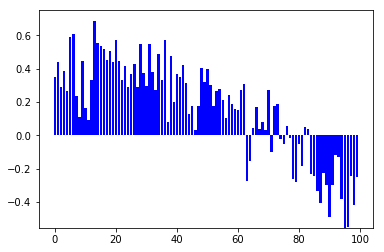

In [157]:
num=np.arange(len(n_grorate))
plt.bar(num,n_grorate, color = 'b')
plt.show()

In [148]:
data1

,2017-02-20/2017-02-26
洛阳钼业,-3.050857
西藏城投,-2.802421
阳 光 城,-2.755018
牧原股份,-2.722447
华锐风电,-2.720217
海翔药业,-2.706751
桂东电力,-2.677843
厦门钨业,-2.675909
农业银行,-2.652724
天润曲轴,-2.638243
